In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmos
from astropy.io import fits
import healpy as hp
h = cosmos.H0.value/100

In [2]:
from astropy.coordinates import SkyCoord
from dustmaps.sfd import SFDQuery

sfd = SFDQuery()

In [3]:
random_n = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/eBOSS_QSO_clustering_random-NGC-vDR16.fits')
random_s = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/eBOSS_QSO_clustering_random-SGC-vDR16.fits')

quasar_n = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/eBOSS_QSO_clustering_data-NGC-vDR16.fits')
quasar_s = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/eBOSS_QSO_clustering_data-SGC-vDR16.fits')

In [4]:
Nside = 512
Npix = hp.nside2npix(Nside)
print(f'scale: {hp.nside2resol(Nside, True)} arcmin')

scale: 6.870972823634812 arcmin


In [5]:
density_noz_m_n = density_noz_m_s = None
density_w_noz_m_n = density_w_noz_m_s = None
density_all_m_n = density_all_m_s = None
density_w_all_m_n = density_w_all_m_s = None
# to make vscode happy

In [6]:
for ns in ['n', 's']:
    quasar = locals()['quasar_'+ns]
    random = locals()['random_'+ns]
    w = quasar['WEIGHT_CP']*quasar['WEIGHT_NOZ']*quasar['WEIGHT_SYSTOT']*quasar['WEIGHT_FKP']
    pix = hp.ang2pix(Nside, np.deg2rad(90 - quasar['DEC']), np.deg2rad(quasar['RA']))
    pix_u = np.unique(pix)
    pix_r = hp.ang2pix(Nside, np.deg2rad(90 - random['DEC']), np.deg2rad(random['RA']))
    pix_ur = np.unique(pix_r)

    theta, phi = hp.pix2ang(Nside, pix_u)
    dec = 90 - np.rad2deg(theta)
    ra = np.rad2deg(phi)
    coord = SkyCoord(ra=ra, dec=dec, unit='deg')
    ebv_noz = sfd(coord)
    # non-zero pixels

    theta, phi = hp.pix2ang(Nside, pix_ur)
    dec = 90 - np.rad2deg(theta)
    ra = np.rad2deg(phi)
    coord = SkyCoord(ra=ra, dec=dec, unit='deg')
    ebv_random = sfd(coord)
    # random pixels

    count = np.bincount(pix, minlength=Npix)                                            # number count in each area
    count_w = np.bincount(pix, minlength=Npix, weights=w)                               # number count weighted

    Nbins = 10
    bin_edge = np.linspace(0, 0.15, Nbins+1, True)
    bin_center = (bin_edge[1:] + bin_edge[:-1])/2

    # random pixels
    count_all = count[pix_ur]
    count_w_all = count_w[pix_ur]
    A = ebv_random
    dig = np.digitize(A, bin_edge)

    count_mid = []

    for i in range(1, Nbins+1):
        counts = count_all[dig == i]
        count_mid.append(counts.mean())

    count_mid_w = []
    for i in range(1, Nbins+1):
        counts = count_w_all[dig == i]
        count_mid_w.append(counts.mean())

    locals()['density_all_m_'+ns] = np.array(count_mid) / count_all.mean()
    locals()['density_w_all_m_'+ns] = np.array(count_mid_w) / count_w_all.mean()


    # non-zero pixels
    count_nozero = count[pix_u]
    count_w_nozero = count_w[pix_u]
    A = ebv_noz
    dig = np.digitize(A, bin_edge)

    count_mid = []

    for i in range(1, Nbins+1):
        counts = count_nozero[dig == i]
        count_mid.append(counts.mean())

    count_mid_w = []
    for i in range(1, Nbins+1):
        counts = count_w_nozero[dig == i]
        count_mid_w.append(counts.mean())

    locals()['density_noz_m_'+ns] = np.array(count_mid) / count_nozero.mean()
    locals()['density_w_noz_m_'+ns] = np.array(count_mid_w) / count_w_nozero.mean()

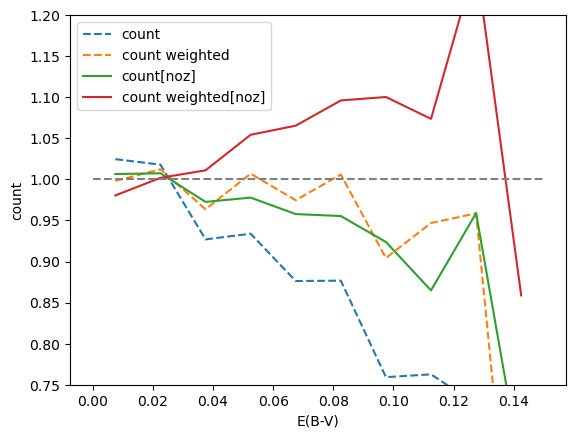

In [13]:
plt.plot(bin_center, density_all_m_n, '--', label='count')      # northern part
plt.plot(bin_center, density_w_all_m_n, '--', label='count weighted')

plt.plot(bin_center, density_noz_m_n, label='count[noz]')
plt.plot(bin_center, density_w_noz_m_n, label='count weighted[noz]')

plt.hlines(1, xmin=0, xmax=0.15, linestyles='--', colors='grey')

plt.ylim(0.75, 1.2)

plt.xlabel('E(B-V)')
plt.ylabel('count')
plt.legend()

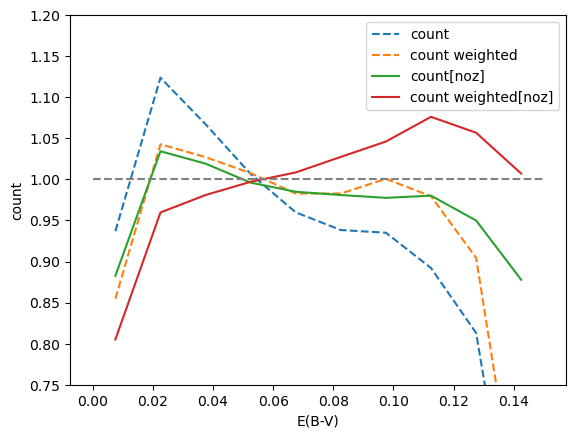

In [12]:
plt.plot(bin_center, density_all_m_s, '--', label='count')      # southern part
plt.plot(bin_center, density_w_all_m_s, '--', label='count weighted')

plt.plot(bin_center, density_noz_m_s, label='count[noz]')
plt.plot(bin_center, density_w_noz_m_s, label='count weighted[noz]')

plt.hlines(1, xmin=0, xmax=0.15, linestyles='--', colors='grey')

plt.ylim(0.75, 1.2)

plt.xlabel('E(B-V)')
plt.ylabel('count')
plt.legend()

In [14]:
# wn = (quasar_n['WEIGHT_CP']*quasar_n['WEIGHT_NOZ']*quasar_n['WEIGHT_SYSTOT']*quasar_n['WEIGHT_FKP']).sum()
# ws = (quasar_s['WEIGHT_CP']*quasar_s['WEIGHT_NOZ']*quasar_s['WEIGHT_SYSTOT']*quasar_s['WEIGHT_FKP']).sum()
random = random_n
pix_r = hp.ang2pix(Nside, np.deg2rad(90 - random['DEC']), np.deg2rad(random['RA']))
pix_ur = np.unique(pix_r)
wn = len(pix_ur)

random = random_s
pix_r = hp.ang2pix(Nside, np.deg2rad(90 - random['DEC']), np.deg2rad(random['RA']))
pix_ur = np.unique(pix_r)
ws = len(pix_ur)

norm = ws+wn
ws /= norm
wn /= norm

In [15]:
density_all = (density_all_m_s*ws + density_all_m_n*wn)
density_w_all = (density_w_all_m_s*ws + density_w_all_m_n*wn)
density_noz = (density_noz_m_s*ws + density_noz_m_n*wn)
density_w_noz = (density_w_noz_m_s*ws + density_w_noz_m_n*wn)

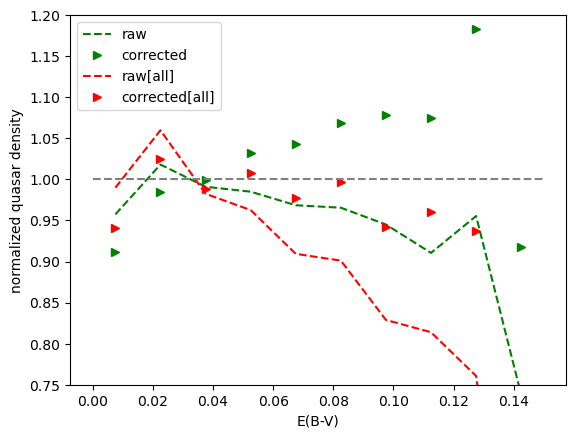

In [16]:
plt.plot(bin_center, density_noz, '--', color='green', label='raw')
plt.plot(bin_center, density_w_noz, '>', color='green', label='corrected')

plt.plot(bin_center, density_all, '--', color='red', label='raw[all]')
plt.plot(bin_center, density_w_all, '>', color='red', label='corrected[all]')

plt.hlines(1, xmin=0, xmax=0.15, linestyles='--', colors='grey')
plt.ylim(0.75, 1.2)
plt.xlabel('E(B-V)')
plt.ylabel('normalized quasar density')
plt.legend()